In [ ]:
# Zachary Katz
# zachary_katz@mines.edu
# 27 October 2025

"""
Example SWOT_L2_PIXC phase ambiguity correction over Amery Ice Shelf topography
by projecting to slant range, seperating regions on different phase ambiguities
using a Gaussian Mixture Model, correcting the phase, then projecting back to
lat/lon.

Note that seperation of the anomaly region uses a Gaussian Mixture Model, which
does not have a set way of defining which label corresponds to the region
we need to correct. Thus, I currently manually change the offset region.

Adapted Brent Williams' tutorial on PODAAC:
https://podaac.github.io/tutorials/notebooks/datasets/SWOT_PIXC_PhaseUnwrap_localmachine.html
"""


### Imports and global variables
import earthaccess
from pathlib import Path
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import mixture
from sklearn.preprocessing import StandardScaler
import cartopy.crs as ccrs

DATA_PATH = "./_Data/UnitTest" 


# Function: Project to slant range
def toslant(pixc, key='height'):
    az = pixc.azimuth_index.astype(int)
    rng = pixc.range_index.astype(int)
    out = np.zeros((pixc.interferogram_size_azimuth + 1, pixc.interferogram_size_range + 1)) + np.nan
    # handle complex interferogram
    if key=='interferogram':
        out = out.astype('complex64')
        real = pixc[key][0, :, 0]
        imag = pixc[key][0, :, 1]
        var = real + 1j * imag
    else:
        var = pixc[key]
    out[az, rng] = var
    return out

In [73]:
# Download example SWOT L2_HR_PIXC data
earthaccess.login()
grans = ['SWOT_L2_HR_PIXC_032_271_025R_20250507T162557_20250507T162608_PID0_02.nc']

for granule in grans:
    karin_results = earthaccess.search_data(short_name = 'SWOT_L2_HR_PIXC_D', granule_name = granule) 
    earthaccess.download(karin_results, DATA_PATH, provider='POCLOUD')

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [50]:
# Load PIXC
PIXCs = list(Path(DATA_PATH).glob('SWOT_L2_HR_PIXC*.nc'))

data_pixc = {'lat': [], 'lon': [], 'height': [], 'quality': [], 'sig0': [], 'phase_unwrap': [], 'class': [], 'corrected_lat': [], 'corrected_lon': [], 'corrected_height': []}
for file in PIXCs[:]:
    print(file)
    ds = xr.open_mfdataset(file,combine='nested',concat_dim="num_lines", decode_times=False,group='pixel_cloud')
    height = ds['height'].isel(num_lines=0)
    quality = ds['geolocation_qual'].isel(num_lines=0)
    lat = ds['latitude']
    lon = ds['longitude']
    sig0 = ds['sig0']
    phase_unwrap = ds['phase_unwrapping_region']
    classif = ds['classification']
    data_pixc['lat'].append(lat)
    data_pixc['lon'].append(lon)
    data_pixc['height'].append(height)
    data_pixc['quality'].append(quality)
    data_pixc['sig0'].append(sig0)
    data_pixc['phase_unwrap'].append(phase_unwrap)
    data_pixc['class'].append(classif)
    data_pixc['corrected_lat'].append(lat)
    data_pixc['corrected_lon'].append(lon)
    data_pixc['corrected_height'].append(height)

_Data/UnitTest/SWOT_L2_HR_PIXC_032_271_025R_20250507T162557_20250507T162608_PID0_02.nc


In [62]:
# Perform Gaussian Mixture Model clustering on PIXC
panel = 0
file = PIXCs[panel]
ds_PIXC = xr.open_mfdataset(file,combine='nested',concat_dim="num_lines", decode_times=False,group='pixel_cloud')
keys = [
    'height',
    'latitude',
    'longitude',
    'phase_unwrapping_region',
    'dheight_dphase',
    'dlatitude_dphase',
    'dlongitude_dphase',
]
# Extract variables in slant range and flatten
ds_slant = {key: toslant(ds_PIXC, key=key) for key in keys}
lat_flat = ds_slant['latitude'].ravel()
lon_flat = ds_slant['longitude'].ravel()
height_flat = ds_slant['height'].ravel()

points = np.column_stack((lat_flat, lon_flat, height_flat))
valid_mask = ~np.isnan(points).any(axis=1)
points_valid = points[valid_mask]

# Fit a Gaussian mixture
X = points_valid
X = StandardScaler().fit_transform(X)
gmm = mixture.GaussianMixture(n_components=4, covariance_type="full",init_params='k-means++').fit(X)


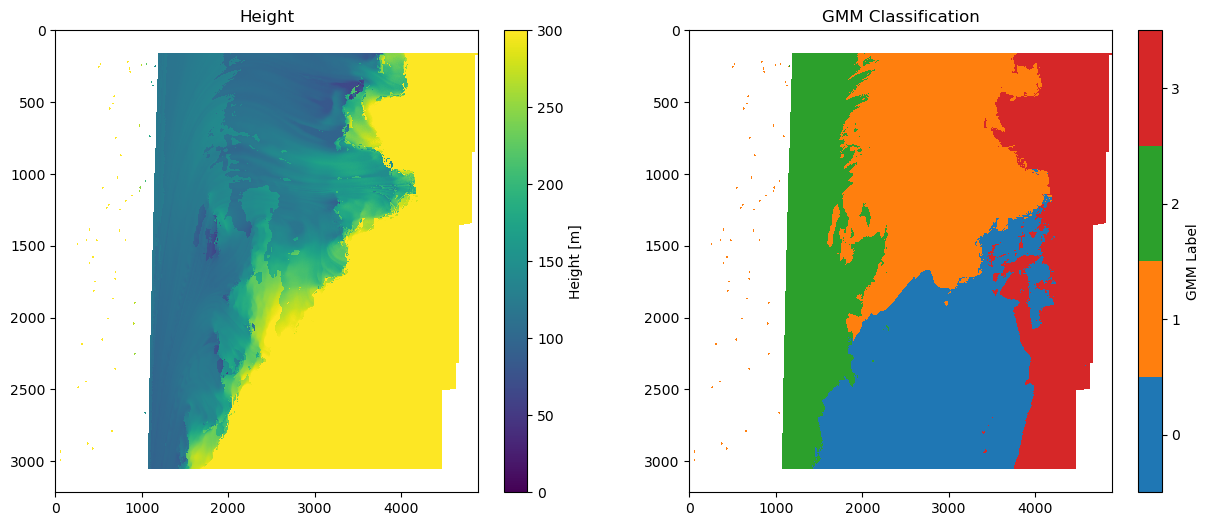

In [74]:
# Plot height and classification 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
cl_ht = ax1.imshow(ds_slant['height'], interpolation='none', cmap='viridis', aspect='auto', vmin=0, vmax=300)
ax1.set_title("Height")
cbar = fig.colorbar(cl_ht, ax=ax1, orientation='vertical', label='Height [m]')

labels = np.full(points.shape[0], np.nan)
labels[valid_mask] = gmm.predict(X)
labels = labels.reshape(ds_slant['latitude'].shape)
cmap = mpl.colors.ListedColormap(plt.cm.tab10.colors[:4])
cl_class = ax2.imshow(labels, interpolation='none', cmap=cmap, aspect='auto')
ax2.set_title("GMM Classification")
cbar = fig.colorbar(cl_class, ax=ax2, orientation='vertical', label='GMM Label')
cbar.set_ticks([0.375, 1.125, 1.875, 2.625])
cbar.set_ticklabels(['0', '1', '2', '3'])

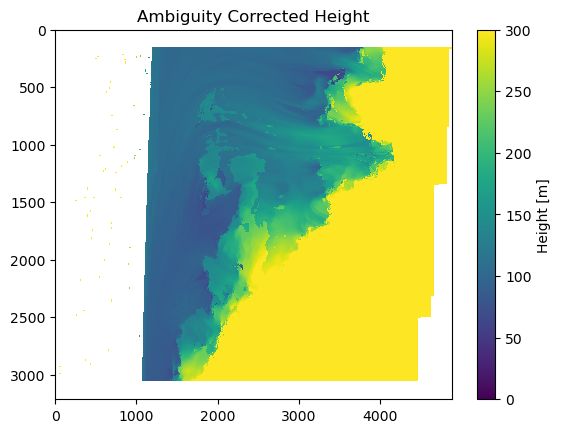

In [75]:
# Manually put ambiguity back in its correct place

##########################################################
#### SET LABEL VALUE OF OFFSET REGION FROM PLOT ABOVE ####
mask = (labels == 2) 

#### SET PHASE AMBIGUITY ###
n = -1 # Typically try +1 or -1
##########################################################

corrected_height = ds_slant['height'].copy()
corrected_height[mask] += ds_slant['dheight_dphase'][mask] * (2*n*np.pi)
corrected_lat =  ds_slant['latitude'].copy()
corrected_lon = ds_slant['longitude'].copy()

# These are estimates, but very close if only within a few phase ambiguities
corrected_lat[mask] += ds_slant['dlatitude_dphase'][mask] * (2*n*np.pi)
corrected_lon[mask] += ds_slant['dlongitude_dphase'][mask]  * (2*n*np.pi)

# Plot
corrected_height = corrected_height.reshape( ds_slant['latitude'].shape)

data_pixc['corrected_lat'][panel] = corrected_lat
data_pixc['corrected_lon'][panel] = corrected_lon
data_pixc['corrected_height'][panel] = corrected_height

fig, ax = plt.subplots()
corr_ht = ax.imshow(corrected_height, interpolation='none', cmap='viridis', aspect='auto', vmin=0, vmax=300)
ax.set_title("Ambiguity Corrected Height")
cbar = fig.colorbar(corr_ht, ax=ax, orientation='vertical', label='Height [m]')


(630000.0, 760000.0)

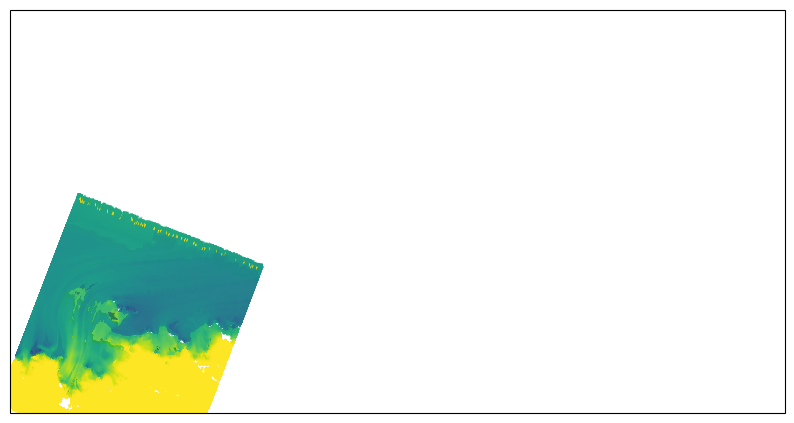

In [72]:
# Scatter subset of corrected data in PS71
# Plot without background maps as a minimal working example

vmin = 0
vmax = 200
# Setup in Antarctic Polar Stereographic
bbox = [1890000,630000,2140000,760000] #Amery + some
ps71_projection = ccrs.Stereographic(central_latitude=-90, central_longitude=0, true_scale_latitude=-71)
fig, ax = plt.subplots(subplot_kw={'projection': ps71_projection}, figsize=(10, 8))

pcm = ax.scatter(data_pixc['corrected_lon'][0], data_pixc['corrected_lat'][0], c=data_pixc['corrected_height'][0], cmap='viridis', s=0.01, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
ax.set_xlim(bbox[0],bbox[2])
ax.set_ylim(bbox[1],bbox[3])
